### Maestría: Computación de Alto Desempeño

##### Autor: **Sebastián Acosta Lasso**
##### Tema: **Técnicas de Machine Learning No Supervisado con el ecosistema Apache Spark en Google Colab**



# Procesamiento de Datos a Gran Escala: Clustering con PySpark


1. Preparación del entorno de ejecución en Google Colab (Java, Spark y PySpark).
2. Carga del dataset **Iris** desde `scikit-learn` y conversión a un DataFrame de Spark.
3. Exploración inicial de los datos y verificación de su estructura.
4. Preparación de las características para el algoritmo de clustering (VectorAssembler y escalamiento).
5. Aplicación del algoritmo **K-means** para agrupar observaciones en clusters.
6. Evaluación cualitativa de los resultados mediante el método del codo y visualizaciones.



## 1. Configuración del entorno en Google Colab



Se instala Java, descarga Spark y configura las variables de entorno esenciales.


In [1]:
# Instalar Java (requerido para Spark)
!apt-get update > /dev/null 2>&1
!apt-get install -y openjdk-8-jdk > /dev/null 2>&1
!update-alternatives --install /usr/bin/java java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java 1 > /dev/null 2>&1

In [2]:
# Instalar PySpark
!pip install pyspark==3.5.0 > /dev/null 2>&1
!pip install findspark > /dev/null 2>&1

In [3]:
import findspark
import os
import warnings

# Suprimir warnings
warnings.filterwarnings('ignore')

# Configurar variables de entorno para Spark
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'

findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

In [4]:
# Crear sesión de Spark optimizada para Colab
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ML_Supervisado_Titanic_SebastianAcosta") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.scheduler.mode", "FAIR") \
    .getOrCreate()

# Suprimir logs de Spark
spark.sparkContext.setLogLevel("ERROR")
spark

## 2. Carga y exploración del dataset Iris

El dataset **Iris** es uno de los más conocidos en *machine learning*.  
Contiene medidas de sépalos y pétalos de tres especies distintas de flores de Iris.

En esta sección se carga los datos utilizando `scikit-learn`, se convierten a un DataFrame de Spark y se realiza una exploración inicial.


In [5]:

from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
iris_pd = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_pd["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)

df_iris = spark.createDataFrame(iris_pd)

df_iris.printSchema()
df_iris.show(5)

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- species: string (nullable = true)

+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
|              5.1|             3.5|              1.4|             0.2| setosa|
|              4.9|             3.0|              1.4|             0.2| setosa|
|              4.7|             3.2|              1.3|             0.2| setosa|
|              4.6|             3.1|              1.5|             0.2| setosa|
|              5.0|             3.6|              1.4|             0.2| setosa|
+-----------------+----------------+-----------------+----------------+-------+
only showing top 5 rows



In [6]:
# En esta celda se calcula estadísticas descriptivas sobre las columnas numéricas del dataset Iris para entender rangos y distribución.
numeric_cols = df_iris.columns[:-1]  # todas menos 'species'
df_iris.select(numeric_cols).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary| sepal length (cm)|  sepal width (cm)| petal length (cm)|  petal width (cm)|
+-------+------------------+------------------+------------------+------------------+
|  count|               150|               150|               150|               150|
|   mean| 5.843333333333332|3.0573333333333337| 3.758000000000001|1.1993333333333331|
| stddev|0.8280661279778628|0.4358662849366982|1.7652982332594664|0.7622376689603467|
|    min|               4.3|               2.0|               1.0|               0.1|
|    max|               7.9|               4.4|               6.9|               2.5|
+-------+------------------+------------------+------------------+------------------+



## 3. Preparación de características para clustering

El algoritmo K-means requiere un vector de características numéricas.  
En esta sección se ensambla las columnas numéricas en una sola columna `features` y opcionalmente aplica un escalamiento para mejorar la estabilidad del algoritmo.


In [7]:
# En esta celda se utiliza `VectorAssembler` para combinar las cuatro características numéricas en una sola columna tipo vector llamada `features`.
from pyspark.ml.feature import VectorAssembler

feature_cols = df_iris.columns[:-1]  # se excluye 'species'
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

df_features = assembler.transform(df_iris).select("features", "species")
df_features.show(5, truncate=False)

+-----------------+-------+
|features         |species|
+-----------------+-------+
|[5.1,3.5,1.4,0.2]|setosa |
|[4.9,3.0,1.4,0.2]|setosa |
|[4.7,3.2,1.3,0.2]|setosa |
|[4.6,3.1,1.5,0.2]|setosa |
|[5.0,3.6,1.4,0.2]|setosa |
+-----------------+-------+
only showing top 5 rows



In [8]:
# En esta celda se aplica `StandardScaler` para normalizar las características y evitar que las magnitudes diferentes de las variables afecten de forma desbalanceada al algoritmo K-means.
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features).select("scaledFeatures", "species")
df_scaled.show(5, truncate=False)

+----------------------------------------------------------------------------------+-------+
|scaledFeatures                                                                    |species|
+----------------------------------------------------------------------------------+-------+
|[-0.8976738791967652,1.015601990713636,-1.3357516342415199,-1.3110521482051303]   |setosa |
|[-1.1392004834649525,-0.13153881205025755,-1.3357516342415199,-1.3110521482051303]|setosa |
|[-1.3807270877331406,0.3273175090553003,-1.3923992862449772,-1.3110521482051303]  |setosa |
|[-1.5014903898672354,0.09788934850252139,-1.2791039822380628,-1.3110521482051303] |setosa |
|[-1.0184371813308588,1.245030151266415,-1.3357516342415199,-1.3110521482051303]   |setosa |
+----------------------------------------------------------------------------------+-------+
only showing top 5 rows



## 4. Entrenamiento del modelo de clustering K-means

Una vez que las características han sido ensambladas y escaladas, se aplica el algoritmo **K-means** para encontrar grupos (clusters) dentro del dataset.

Primero se explora el número adecuado de clusters utilizando el método del codo, y luego se analiza en detalle el caso particular de `k = 3`, que coincide con las tres especies de Iris.


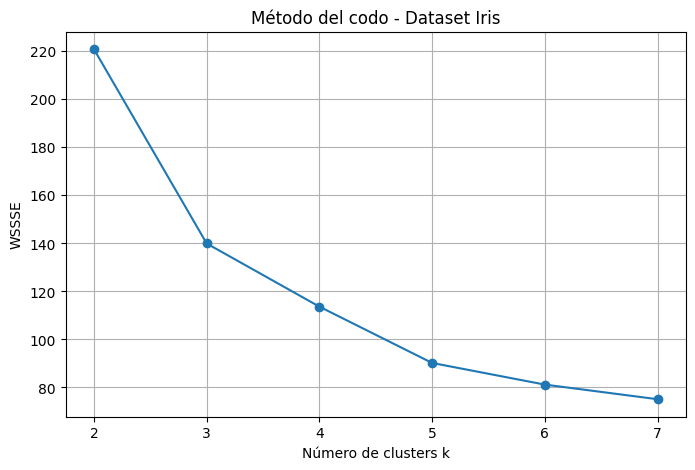

In [9]:
# En esta celda se ejecuta K-means para diferentes valores de k y calcula el *Within-Cluster Sum of Squared Errors* (WSSSE) para aplicar el método del codo.
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

k_values = list(range(2, 8))
wssse_values = []

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol="scaledFeatures")
    model = kmeans.fit(df_scaled)
    wssse = model.summary.trainingCost
    wssse_values.append(wssse)

# Visualización del método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, wssse_values, marker="o")
plt.title("Método del codo - Dataset Iris")
plt.xlabel("Número de clusters k")
plt.ylabel("WSSSE")
plt.grid(True)
plt.show()

In [10]:
# En esta celda se entrena un modelo K-means con k = 3 y se explora los clusters resultantes.
kmeans_3 = KMeans(k=3, seed=42, featuresCol="scaledFeatures")
model_3 = kmeans_3.fit(df_scaled)

centers = model_3.clusterCenters()
print("Centros de los 3 clusters:")
for idx, center in enumerate(centers):
    print(f"Cluster {idx}: {center}")

Centros de los 3 clusters:
Cluster 0: [-0.16784349 -0.96945035  0.25900292  0.17484752]
Cluster 1: [-0.99872072  0.90322901 -1.29875725 -1.25214931]
Cluster 2: [1.03014756 0.00611808 0.94045402 0.9693151 ]


In [11]:
# En esta celda se asigna cada observación a un cluster y guarda el resultado en un nuevo DataFrame para su posterior análisis y visualización.
df_clusters = model_3.transform(df_scaled)
df_clusters.select("species", "prediction").show(10)

+-------+----------+
|species|prediction|
+-------+----------+
| setosa|         1|
| setosa|         1|
| setosa|         1|
| setosa|         1|
| setosa|         1|
| setosa|         1|
| setosa|         1|
| setosa|         1|
| setosa|         1|
| setosa|         1|
+-------+----------+
only showing top 10 rows



## 5. Visualización de los resultados de clustering

Aunque el modelo se ha entrenado en un espacio de cuatro dimensiones, es útil visualizar los resultados en 2D para tener una idea intuitiva de la separación de los clusters.

En esta sección se proyecta los datos a un gráfico de dispersión usando dos de las características originales.


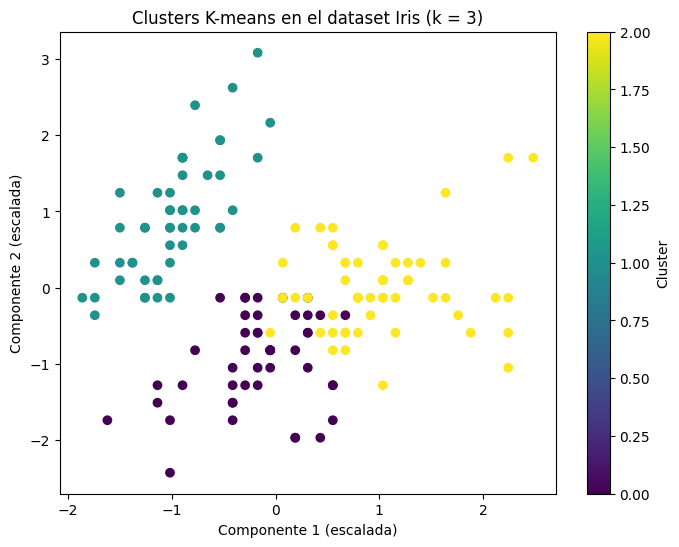

In [12]:
# En esta celda se convierte el DataFrame de Spark con los clusters asignados a un DataFrame de pandas y crea una gráfica de dispersión para visualizar la separación de los grupos.
import numpy as np

df_viz_pd = df_clusters.select("scaledFeatures", "species", "prediction").toPandas()

# Extraer dos dimensiones para visualizar (por ejemplo, componentes 0 y 1)
x = df_viz_pd["scaledFeatures"].apply(lambda v: float(v[0]))
y = df_viz_pd["scaledFeatures"].apply(lambda v: float(v[1]))
clusters = df_viz_pd["prediction"].values

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=clusters, cmap="viridis")
plt.xlabel("Componente 1 (escalada)")
plt.ylabel("Componente 2 (escalada)")
plt.title("Clusters K-means en el dataset Iris (k = 3)")
plt.colorbar(scatter, label="Cluster")
plt.show()

## 6. Conclusiones del cuaderno no supervisado

En este cuaderno:

-Se logró configurar un entorno de trabajo en Google Colab para ejecutar PySpark, lo que permitió desarrollar el proceso completo de análisis de datos de manera adecuada.

-Se cargó y exploró el dataset clásico Iris, comprendiendo sus características y reafirmando su utilidad en tareas de clasificación y clustering.

-Se prepararon las variables numéricas mediante ensamblado y escalamiento, garantizando que los datos estuvieran en condiciones óptimas para aplicar métodos de aprendizaje automático.

-Se aplicó el algoritmo K-means y se observaron los agrupamientos formados a partir de las similitudes entre las observaciones.

-A través del método del codo, se analizó el número adecuado de clusters, lo que permitió tomar una decisión fundamentada sobre la configuración del modelo.

-Finalmente, la visualización de los resultados permitió confirmar que los clusters generados corresponden en buena medida a las tres especies del dataset, validando la efectividad del proceso realizado.


